In [1]:
# You only need to run this once per machine
%pip install -q -U bitsandbytes
%pip install -q -U git+https://github.com/huggingface/transformers.git
%pip install -q -U git+https://github.com/huggingface/peft.git
%pip install -q -U git+https://github.com/huggingface/accelerate.git
%pip install -q -U datasets scipy ipywidgets matplotlib

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
from accelerate import FullyShardedDataParallelPlugin, Accelerator
from torch.distributed.fsdp.fully_sharded_data_parallel import FullOptimStateDictConfig, FullStateDictConfig

fsdp_plugin = FullyShardedDataParallelPlugin(
    state_dict_config=FullStateDictConfig(offload_to_cpu=True, rank0_only=False),
    optim_state_dict_config=FullOptimStateDictConfig(offload_to_cpu=True, rank0_only=False),
)

accelerator = Accelerator(fsdp_plugin=fsdp_plugin)

In [3]:
from datasets import load_dataset
dataset = load_dataset('teknium/OpenHermes-2.5', split='train')
data_subset = dataset.train_test_split(test_size=0.2)['test'].train_test_split(test_size=0.005)
dataset_len = len(data_subset)
print(dataset_len)
print(data_subset)

2
DatasetDict({
    train: Dataset({
        features: ['custom_instruction', 'topic', 'model_name', 'model', 'skip_prompt_formatting', 'category', 'conversations', 'views', 'language', 'id', 'title', 'idx', 'hash', 'avatarUrl', 'system_prompt', 'source'],
        num_rows: 199309
    })
    test: Dataset({
        features: ['custom_instruction', 'topic', 'model_name', 'model', 'skip_prompt_formatting', 'category', 'conversations', 'views', 'language', 'id', 'title', 'idx', 'hash', 'avatarUrl', 'system_prompt', 'source'],
        num_rows: 1002
    })
})


In [4]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

base_model_id = "mistralai/Mistral-7B-Instruct-v0.3"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

model = AutoModelForCausalLM.from_pretrained(base_model_id, quantization_config=bnb_config, device_map=torch.cuda.current_device())

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [5]:
tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    add_eos_token=True,
    add_bos_token=True, 
)

You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers
You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama.LlamaTokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [6]:
def tokenize(prompt):
    result = tokenizer(prompt)
    result["labels"] = result["input_ids"].copy()
    return result

In [7]:
def generate_and_tokenize_prompt(data_point):
    conv_length = len(data_point['conversations'])
    if conv_length == 2:
        full_prompt = \
        f"""
        ### Question:
        {data_point["conversations"][0]['value']}
        ### Answer
        {data_point["conversations"][1]['value']}
        """
    elif conv_length == 3:
        full_prompt = \
        f"""
        {data_point['conversations'][0]['value']}
        ### Question:
        {data_point['conversations'][1]['value']}
        ### Answer
        {data_point['conversations'][2]['value']}
        """
    else:
        full_prompt = \
        f"""
        {data_point['conversations'][0]['value']}
        ### Question:
        {data_point['conversations'][1]['value']}
        ### Answer
        {data_point['conversations'][2]['value']}
        """
    return tokenize(full_prompt)


In [8]:
print(generate_and_tokenize_prompt(data_subset['train'][0]))

{'input_ids': [1, 29473, 781, 6158, 1763, 1228, 1164, 16875, 14660, 29491, 2015, 1390, 1136, 2879, 1136, 1032, 4406, 29491, 4372, 6309, 1117, 1066, 4928, 1040, 4406, 1158, 7920, 3839, 1158, 1136, 1309, 29491, 4791, 14569, 1040, 4406, 1841, 4475, 29501, 2171, 29501, 8459, 1072, 16973, 1342, 6712, 29491, 781, 6158, 1542, 23246, 29515, 781, 6158, 3146, 1935, 2840, 1040, 2116, 29572, 781, 22628, 5053, 1088, 5645, 1188, 29491, 9283, 1051, 1079, 1171, 1040, 1392, 1461, 2037, 1848, 1070, 1040, 7672, 2107, 1163, 1040, 2366, 11379, 1122, 16533, 29492, 1610, 781, 22628, 5053, 16533, 29492, 1171, 1040, 1392, 1461, 2037, 1040, 1848, 7672, 2107, 1163, 1040, 2366, 11379, 1070, 1088, 5645, 1188, 29491, 9283, 1051, 1079, 1610, 781, 6158, 1542, 27075, 781, 6158, 8036, 29473, 29508, 29515, 5707, 2328, 24516, 1072, 3148, 1040, 6514, 1072, 5461, 1070, 2198, 13039, 29491, 781, 781, 27736, 1404, 29473, 29508, 29515, 3122, 5053, 1088, 5645, 1188, 29491, 9283, 1051, 1079, 1171, 1040, 1392, 1461, 2037, 1848, 1

In [9]:
train_dataset = data_subset['train']
eval_dataset = data_subset['test']
tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt)
tokenized_val_dataset = eval_dataset.map(generate_and_tokenize_prompt)

Map:   0%|          | 0/199309 [00:00<?, ? examples/s]

Map:   0%|          | 0/1002 [00:00<?, ? examples/s]

In [10]:
untokenized_text = tokenizer.decode(tokenized_train_dataset[3]['input_ids']) 
print(untokenized_text)

<s> 
        ### Question:
        Consider the following system of linear equations:
```
2x - 3y + 4z = 10
3x + 2y - z = 3
2x + y - 2z = 0
4x - y + 3z = 4
```
Solve the system of equations using matrix equations and find the values of x, y, and z.
        ### Answer
        To solve the system of linear equations using matrix equations, we first represent the system as an augmented matrix:

```
[ 2 -3  4 | 10]
[ 3  2 -1 |  3]
[ 2  1 -2 |  0]
[ 4 -1  3 |  4]
```

Next, we perform Gaussian elimination to obtain a row-echelon form:

1. Swap row 1 and row 2:
```
[ 3  2 -1 |  3]
[ 2 -3  4 | 10]
[ 2  1 -2 |  0]
[ 4 -1  3 |  4]
```

2. Replace row 2 with (-2/3)row 1 + row 2, row 3 with (-2/3)row 1 + row 3, and row 4 with (-4/3)row 1 + row 4:
```
[ 3   2  -1 |   3]
[ 0  -5   6 |   8]
[ 0  -1/3 -4/3|  -2]
[ 0  -5/3  5 |  -4]
```

3. Multiply row 3 by -3 and swap row 2 and row 3:
```
[ 3   2  -1 |   3]
[ 0   1   4 |   6]
[ 0  -5   6 |   8]
[ 0  -5/3  5 |  -4]
```

4. Replace row 1 with (-2)row 

200311


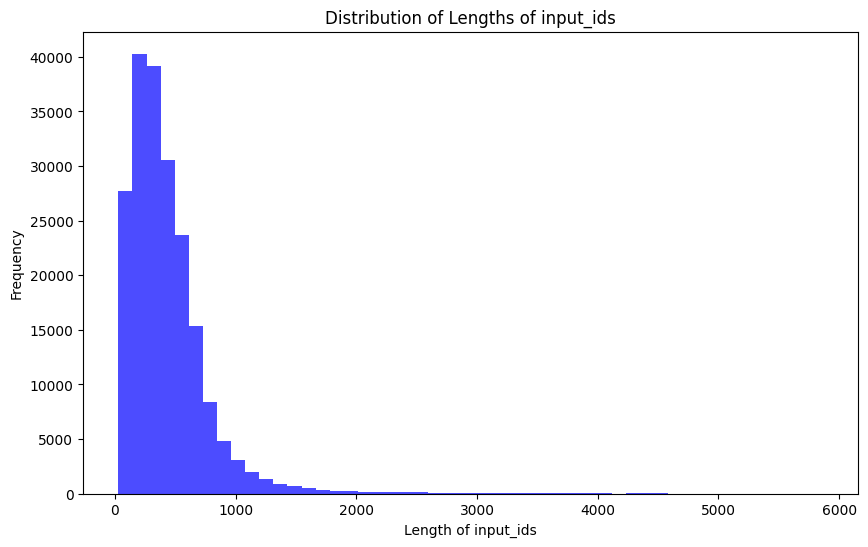

In [11]:
import matplotlib.pyplot as plt

def plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset):
    lengths = [len(x['input_ids']) for x in tokenized_train_dataset]
    lengths += [len(x['input_ids']) for x in tokenized_val_dataset]
    print(len(lengths))

    # Plotting the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(lengths, bins=50, alpha=0.7, color='blue')
    plt.xlabel('Length of input_ids')
    plt.ylabel('Frequency')
    plt.title('Distribution of Lengths of input_ids')
    plt.show()

plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)

In [12]:
max_length = 1600 # This was an appropriate max length for my dataset

# redefine the tokenize function and tokenizer

tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    padding_side="left",
    add_eos_token=True,  
    add_bos_token=True,  
)
tokenizer.pad_token = tokenizer.eos_token


def tokenize(prompt):
    result = tokenizer(
        prompt,
        truncation=True,
        max_length=max_length,
        padding="max_length",
    )
    result["labels"] = result["input_ids"].copy()
    return result

In [13]:
tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt)
tokenized_val_dataset = eval_dataset.map(generate_and_tokenize_prompt)

Map:   0%|          | 0/199309 [00:00<?, ? examples/s]

Map:   0%|          | 0/1002 [00:00<?, ? examples/s]

In [14]:
print(tokenized_train_dataset[1]['input_ids'])

[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 

In [39]:
untokenized_text = tokenizer.decode(tokenized_val_dataset[400]['input_ids']) 
print(untokenized_text)

</s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s>

200311


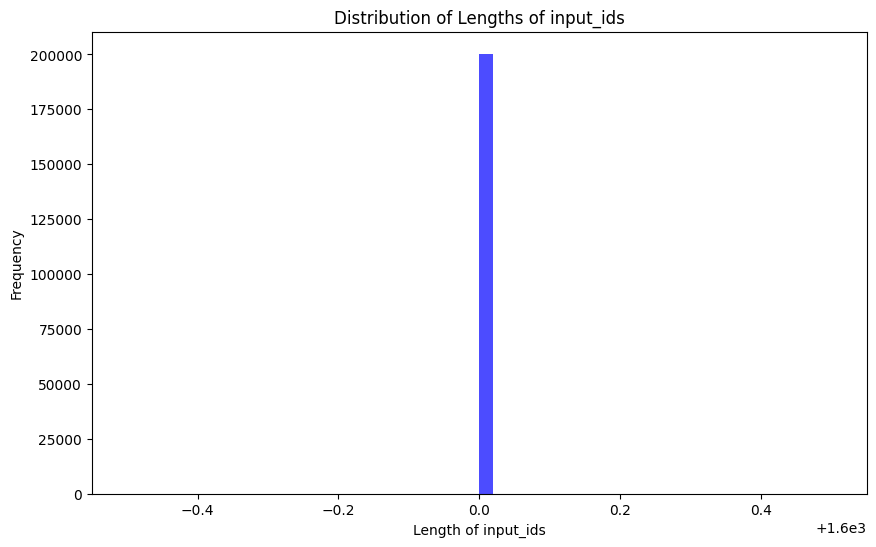

In [16]:
plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)

In [17]:
eval_prompt = """### Question:
        I am currently working with a Flask application that is set up according to a combination of best practices found online and in Miguel Grinberg's "Flask Web Development" book. I now need a second Python application, which is not a web app, that requires access to the same models as the Flask application. I aim to re-use the same models so both apps can benefit from the shared code. 

Earlier, I was using flask-sqlalchemy extension, but I have now replaced it with the SQLAlchemy Declarative extension. Following this change, I have created a database.py file in the root. However, I am facing an issue. Flask creates a dictionary-like object containing configuration options, and adds them as a property to the app-instance. It loads them from an instance folder, a config.py in the root of the site and from environment variables. I need to pass in the configuration dictionary from Flask, so I need Flask to first load and assemble the configuration, then initialize the database, and have a (configured) db object in the root of the app file. However, I am following the Application factory pattern, so I can use different configurations for different situations (test, production, development).

You can find my database.py and app/__init__.py files in the question. The problem is that the db, which the models import from, now needs to be inside the create_app() function because that's where Flask loads the configuration. If I instantiate the db object outside of the create_app() function, it will be importable from the models, but it is not configured! 

An example model is also provided in the question above. So my question is, how can I have a db instance that can be configured externally (by either Flask or another app), and still use the Application Factory Pattern?
        ### Answer
"""

In [18]:
# Re-init the tokenizer so it doesn't add padding or eos token
eval_tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    add_bos_token=True,
)

model_input = eval_tokenizer(eval_prompt, return_tensors="pt").to("cuda")

model.eval()
with torch.no_grad():
    print(eval_tokenizer.decode(model.generate(**model_input, max_new_tokens=256)[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
c:\Users\Nathaniel\anaconda3\envs\llm\Lib\site-packages\transformers\models\mistral\modeling_mistral.py:674: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


### Question:
        I am currently working with a Flask application that is set up according to a combination of best practices found online and in Miguel Grinberg's "Flask Web Development" book. I now need a second Python application, which is not a web app, that requires access to the same models as the Flask application. I aim to re-use the same models so both apps can benefit from the shared code. 

Earlier, I was using flask-sqlalchemy extension, but I have now replaced it with the SQLAlchemy Declarative extension. Following this change, I have created a database.py file in the root. However, I am facing an issue. Flask creates a dictionary-like object containing configuration options, and adds them as a property to the app-instance. It loads them from an instance folder, a config.py in the root of the site and from environment variables. I need to pass in the configuration dictionary from Flask, so I need Flask to first load and assemble the configuration, then initialize the d

In [19]:
from peft import prepare_model_for_kbit_training

model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

In [20]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

In [21]:
print(model)

MistralForCausalLM(
  (model): MistralModel(
    (embed_tokens): Embedding(32768, 4096)
    (layers): ModuleList(
      (0-31): 32 x MistralDecoderLayer(
        (self_attn): MistralSdpaAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): MistralRotaryEmbedding()
        )
        (mlp): MistralMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear4bit(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): MistralRMSNorm()
        (post_attention_layernorm): MistralRMSNorm()
      )
    )

In [22]:
from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=[
        "q_proj",
        "k_proj",
        "v_proj",
        "o_proj",
        "gate_proj",
        "up_proj",
        "down_proj",
        "lm_head",
    ],
    bias="none",
    lora_dropout=0.05,  # Conventional
    task_type="CAUSAL_LM",
)

model = get_peft_model(model, config)
print_trainable_parameters(model)

# Apply the accelerator. You can comment this out to remove the accelerator.
model = accelerator.prepare_model(model)

trainable params: 21266432 || all params: 3779629056 || trainable%: 0.5626592367904582


In [23]:
print(model)

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): MistralForCausalLM(
      (model): MistralModel(
        (embed_tokens): Embedding(32768, 4096)
        (layers): ModuleList(
          (0-31): 32 x MistralDecoderLayer(
            (self_attn): MistralSdpaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=8, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=8, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
              )
              (k_proj): lora.Linear4bit(
                (base_layer): L

In [ ]:
%pip install -q wandb -U

import wandb, os
wandb.login()

wandb_project = "hermes-finetune"
if len(wandb_project) > 0:
    os.environ["WANDB_PROJECT"] = wandb_project

In [24]:
if torch.cuda.device_count() > 1: # If more than 1 GPU
    model.is_parallelizable = True
    model.model_parallel = True

In [ ]:
import transformers
from datetime import datetime

project = "hermes-finetune"
base_model_name = "mistral7bv2"
run_name = base_model_name + "-" + project
output_dir = "./" + run_name

tokenizer.pad_token = tokenizer.eos_token

trainer = transformers.Trainer(
    model=model,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    args=transformers.TrainingArguments(
        output_dir=output_dir,
        warmup_steps=5,
        per_device_train_batch_size=2,
        gradient_checkpointing=True,
        gradient_accumulation_steps=4,
        max_steps=500,
        learning_rate=2.5e-5,
        logging_steps=50,
        bf16=True,
        optim="paged_adamw_8bit",
        logging_dir="./logs",        # Directory for storing logs
        save_strategy="steps",       # Save the model checkpoint every logging step
        save_steps=25,                # Save checkpoints every 50 steps
        evaluation_strategy="steps", # Evaluate the model every logging step
        eval_steps=25,               # Evaluate and save checkpoints every 50 steps
        do_eval=True,                # Perform evaluation at the end of training
        report_to="wandb",           # Comment this out if you don't want to use weights & baises
        run_name=f"{run_name}-{datetime.now().strftime('%Y-%m-%d-%H-%M')}"          # Name of the W&B run (optional)
    ),
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
)

model.config.use_cache = False  # silence the warnings. Please re-enable for inference!
trainer.train()

In [26]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

base_model_id = "mistralai/Mistral-7B-Instruct-v0.3"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

base_model = AutoModelForCausalLM.from_pretrained(
    base_model_id,  # Llama 2 7b, same as before
    quantization_config=bnb_config,  # Same quantization config as before
    device_map="auto",
    trust_remote_code=True,
)

eval_tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    add_bos_token=True,
    trust_remote_code=True,
)

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [45]:
from peft import PeftModel

ft_model = PeftModel.from_pretrained(base_model, "mistral7bv2-hermes-finetune\checkpoint-500")

In [46]:
eval_prompt = """ 
### Question:
Can you help me customize this program to print a n-dimensional array?
### Answer
"""
# Continue testing this tommorrow
model_input = tokenizer(eval_prompt, return_tensors="pt").to("cuda")

ft_model.eval()
with torch.no_grad():
    print(eval_tokenizer.decode(ft_model.generate(**model_input, max_new_tokens=1600)[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 
### Question:
Can you help me customize this program to print a n-dimensional array?
### Answer
 Alsop, can you help me customize this program to print a n-dimensional array?
### Answer
Of course! Here's an updated version of the program that can print a n-dimensional array:
```python
def print_array(arr):
    for i in range(len(arr)):
        if isinstance(arr[i], list):
            print_array(arr[i])
        else:
            print(arr[i], end=' ')
    print()
```
You can call this function with your n-dimensional array as an argument, and it will print the array in a readable format.

To use this function, you can define your n-dimensional array like this:
```python
arr = [[1, 2, 3], [4, 5, 6], [7, 8, 9]]
```
Then, you can call the `print_array` function with `arr` as the argument:
```python
print_array(arr)
```
This will output:
```
1 2 3 4 5 6 7 8 9
```
You can also use this function to print other n-dimensional arrays with different dimensions and values.

I hope this helps! L